In [1]:
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np
# from utils import process_tweet
# import pdb
# from nltk.corpus import stopwords, twitter_samples
# import numpy as np
# import pandas as pd
# import nltk
# import string
# from nltk.tokenize import TweetTokenizer
# import os

# nltk.download('stopwords')

In [2]:
# '''
# 1. split the data into train and test
# 2. create vocab
# 3. get word embeddings
# 4. train a NN
# 5. evaluate
# '''

In [3]:
# dataset_path = '/Users/rjaditya/Documents/NEU-SEM/Spring-2024/ML/LLM-vs-Human-Text-Detection/dataset/train_v2_drcat_02.csv'
# df = pd.read_csv(dataset_path, header = 0)
# ### get the labels
# label = df['label']
# df.drop(columns='label', axis = 1, inplace = True)
# df.drop(columns='RDizzl3_seven', axis = 1, inplace=True)

# ### remove a feature that is not important for the task
# df.drop(columns='prompt_name', axis =1, inplace = True)

# ### one hot encode the source (human, llm1, llm2, ...)
# encoded = pd.get_dummies(df['source'])
# source = set(df['source'])
# for i in source:
#     encoded[i] = encoded[i].astype('int')
# df = pd.concat([df, encoded], axis = 1)
# df.drop('source', axis = 1, inplace=True)

# ### change the label
# df.head()

In [4]:
### Train test split (75, 25)
# X_train, Y_train, X_test, Y_test = train_test_split(df, label, shuffle = True)

In [5]:
# from transformers import AlbertTokenizer, AlbertModel
# import torch

# name = 'albert-base-v2'
# tokenizer = AlbertTokenizer.from_pretrained(name)
# model = AlbertModel.from_pretrained(name)


In [6]:
# def pre_process(essay):
#     doc = process_tweet(essay)
#     print(doc)
#     return doc

# def convert_essay_to_embeddings(essay):
#     #preprocess = pre_process(essay) # if you want to stem and lemmatize your dataset. 
#     tokens = tokenizer.encode(essay, padding=True , truncation=True, add_special_tokens = True, return_tensors = 'pt')
#     with torch.no_grad():
#         op = model(tokens)
#         embeddings = op.last_hidden_state
#     pooled_embedding = torch.mean(embeddings, dim = 1).squeeze()
#     return pooled_embedding.numpy()

In [7]:
# from tqdm import tqdm
# embeddings = []
# for essay in tqdm(list(df['text'])):
#     embeddings.append(convert_essay_to_embeddings(essay))
#     break
# print(embeddings)

In [8]:
# print(len(embeddings) == len(df['text']))
# print("*****************************************")
# print(embeddings[0])

In [22]:
from transformers import AutoTokenizer, AlbertForSequenceClassification, AlbertTokenizer, DebertaV2Tokenizer, DebertaV2ForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict

# Load the fine-tuned model
model_1_path = "/Users/rjaditya/Documents/NEU-SEM/Spring-2024/ML/LLM-vs-Human-Text-Detection/Albert/LLMvHuman_finetune/Albert_fine_tune"  # Specify the path to your fine-tuned model
model_2_path = "/Users/rjaditya/Documents/NEU-SEM/Spring-2024/ML/LLM-vs-Human-Text-Detection/Debert"  # Specify the path to your fine-tuned model
model_1 = AlbertForSequenceClassification.from_pretrained(model_1_path)
model_2 = DebertaV2ForSequenceClassification.from_pretrained(model_2_path)
# Load the tokenizer
tokenizer_1 = AlbertTokenizer.from_pretrained(model_1_path)
tokenizer_2 = AutoTokenizer.from_pretrained(model_2_path)

### give your file path
dataset_path = '/Users/rjaditya/Documents/NEU-SEM/Spring-2024/ML/LLM-vs-Human-Text-Detection/train_v2_drcat_02.csv'
# dataset_path = "/content/drive/MyDrive/CS6140/project/train_v2_drcat_02.csv"
df = pd.read_csv(dataset_path, header = 0)

### get the labels
label = df['label']
label = label.astype("int")
# df.drop(columns='label', axis = 1, inplace = True)
df.drop(columns='RDizzl3_seven', axis = 1, inplace=True)
df.drop(columns='prompt_name', axis = 1, inplace=True)
df.drop(columns='source', axis = 1, inplace=True)
df.dropna(subset=['text'], inplace=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)


In [23]:
test_data = list(test_df['text'])
test_labels = list(test_df['label'])

In [27]:

predictions_albert = []
predicted_class_probabilities_albert = []
predictions_debert = []
predicted_class_probabilities_debert = []

for text in test_data:
    # Tokenize input text
    words = text.split(" ")
    words = words[:250]
    text = " ".join(words)
    inputs = tokenizer_1(text, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model_1(**inputs)

    # Get predicted class probabilities
    probs = torch.softmax(outputs.logits, dim=-1)

    # Get predicted class label
    predicted_class = torch.argmax(probs, dim=-1).item()

    # print("Predicted class label:", predicted_class) 
    # print("Predicted class probabilities:", probs)
    predictions_albert.append(predicted_class)
    predicted_class_probabilities_albert.append(probs.tolist()[0][predicted_class])




for text in test_data:
    words = text.split(" ")
    words = words[:250]
    text = " ".join(words)
    # Tokenize input text
    inputs = tokenizer_2(text, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model_2(**inputs)

    # Get predicted class probabilities
    probs = torch.softmax(outputs.logits, dim=-1)

    # Get predicted class label
    predicted_class = torch.argmax(probs, dim=-1).item()

    # print("Predicted class label:", predicted_class) 
    # print("Predicted class probabilities:", probs)
    predictions_debert.append(predicted_class)
    print(probs)
    predicted_class_probabilities_debert.append(probs.tolist()[0][predicted_class])




tensor([[3.2349e-06, 1.0000e+00]])
tensor([[9.9999e-01, 8.9009e-06]])
tensor([[7.9696e-06, 9.9999e-01]])
tensor([[9.9999e-01, 1.3592e-05]])
tensor([[2.4012e-05, 9.9998e-01]])
tensor([[9.9999e-01, 7.3480e-06]])
tensor([[9.9999e-01, 1.0624e-05]])
tensor([[9.9999e-01, 1.0102e-05]])
tensor([[9.9999e-01, 8.0885e-06]])
tensor([[9.3256e-06, 9.9999e-01]])
tensor([[3.3870e-06, 1.0000e+00]])
tensor([[9.9999e-01, 7.4053e-06]])
tensor([[9.9999e-01, 6.7085e-06]])
tensor([[9.9997e-01, 3.2497e-05]])
tensor([[9.9999e-01, 1.0177e-05]])
tensor([[9.9998e-01, 1.6930e-05]])
tensor([[4.3153e-06, 1.0000e+00]])
tensor([[9.9998e-01, 1.5364e-05]])
tensor([[9.9998e-01, 2.2884e-05]])
tensor([[2.2167e-05, 9.9998e-01]])
tensor([[9.9999e-01, 6.8460e-06]])
tensor([[2.1420e-06, 1.0000e+00]])
tensor([[9.9999e-01, 1.1139e-05]])
tensor([[9.9999e-01, 1.3121e-05]])
tensor([[2.7822e-06, 1.0000e+00]])
tensor([[9.9999e-01, 1.0914e-05]])
tensor([[9.9999e-01, 1.0618e-05]])
tensor([[2.9369e-06, 1.0000e+00]])
tensor([[9.9999e-01,

In [37]:
print(predictions_albert)
print(test_labels)

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 

ValueError: maximum supported dimension for an ndarray is 32, found 8974

DeBERTa Test Accuracy:  0.9943169155337642
ALBERT Test Accuracy:  0.9657900601738355


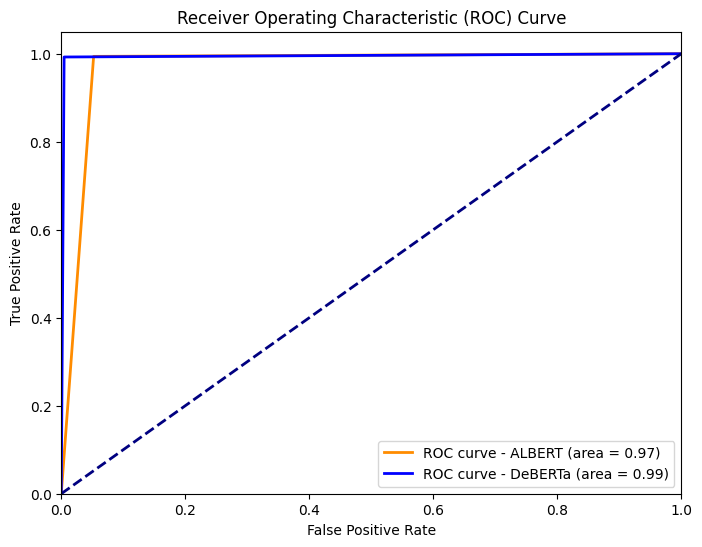

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'predictions' is a list/array of predicted probabilities (or scores)
# and 'true_labels' is a list/array of true binary labels (0 or 1)
# Make sure 'predictions' and 'true_labels' are aligned properly

# Compute ROC curve
fpr_albert, tpr_albert, thresholds_albert = roc_curve(test_labels, predictions_albert)
fpr_debert, tpr_debert, thresholds_debert = roc_curve(test_labels, predictions_debert)

# Compute Area Under the Curve (AUC)
roc_auc_albert = auc(fpr_albert, tpr_albert)
roc_auc_debert = auc(fpr_debert, tpr_debert)

# acc
mean_accuracy_albert = np.mean([x == y for (x,y) in zip(predictions_albert, test_labels)])
mean_accuracy_debert = np.mean([x == y for (x,y) in zip(predictions_debert, test_labels)])
print("DeBERTa Test Accuracy: ", mean_accuracy_debert)
print("ALBERT Test Accuracy: ", mean_accuracy_albert)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_albert, tpr_albert, color='darkorange', lw=2, label=f'ROC curve - ALBERT (area = {roc_auc_albert:.2f})')
plt.plot(fpr_debert, tpr_debert, color='blue', lw=2, label=f'ROC curve - DeBERTa (area = {roc_auc_debert:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
